In [259]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler, MinMaxScaler

In [260]:
df=pd.read_csv("../../data/modelers_data.csv").drop(columns=['index'])
df

,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty
0,msi,MSI Modern 15 B7M-072IN Laptop (Ryzen 5 7530U/...,43990,53,amd,ryzen 5,6,12,8,SSD,...,No secondary storage,0,amd,integrated,False,15.6,1920,1080,windows,1
1,msi,MSI Prestige 16 A13UCX-250IN Laptop (13th Gen ...,119990,73,intel,core i7,14,20,16,SSD,...,No secondary storage,0,nvidia,dedicated,False,16.0,2560,1600,windows,2
2,acer,Acer Aspire 7 A715-75G Gaming Laptop (10th Gen...,45990,59,intel,core i5,4,8,8,SSD,...,No secondary storage,0,nvidia,dedicated,False,15.6,1920,1080,windows,1
3,msi,MSI CreatorPro Z16 HX B13VKTO-214IN Laptop (13...,449990,89,intel,core i9,24,32,4,SSD,...,No secondary storage,0,nvidia,dedicated,False,16.0,2560,1600,windows,2
4,acer,Acer Aspire 3 Spin 14 NX.KENSI.002 Laptop (Int...,41490,45,intel,core i3,8,8,8,SSD,...,No secondary storage,0,intel,integrated,False,14.0,1920,1200,windows,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,acer,Acer Aspire Lite AL15 Laptop (AMD Ryzen 5 5500...,37990,60,amd,ryzen 5,6,12,16,SSD,...,No secondary storage,0,amd,integrated,False,15.6,1920,1080,windows,1
689,hp,HP Victus 15-fb0050AX Gaming Laptop (AMD Ryzen...,59871,71,amd,ryzen 5,6,12,8,SSD,...,No secondary storage,0,nvidia,dedicated,False,15.6,1920,1080,windows,1
690,dell,Dell Vostro 15 3510 2023 Laptop (11th Gen Core...,47990,63,intel,core i5,4,8,8,SSD,...,No secondary storage,0,intel,integrated,False,15.6,1920,1080,windows,1
691,hp,HP 240 G9 821J4PA Laptop (12th Gen Core i5/ 8G...,74999,64,intel,core i5,10,12,8,SSD,...,No secondary storage,0,intel,integrated,False,14.0,1366,768,windows,1


# Resolution switch

<Axes: xlabel='resolution_width', ylabel='resolution_height'>

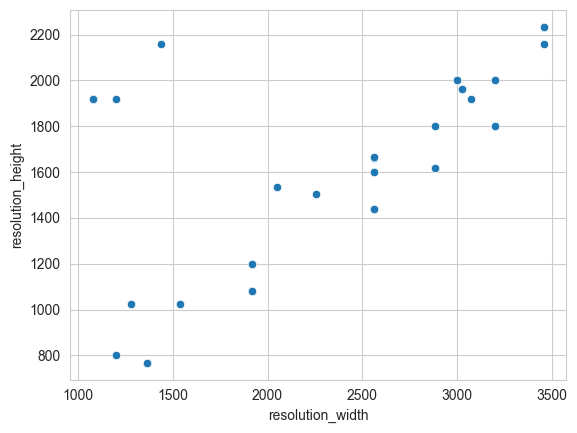

In [261]:
# create distribution plot 2d for resolution width and height using scatter plot
sns.scatterplot(data=df,x='resolution_width',y='resolution_height')

<Axes: xlabel='resolution_width', ylabel='resolution_height'>

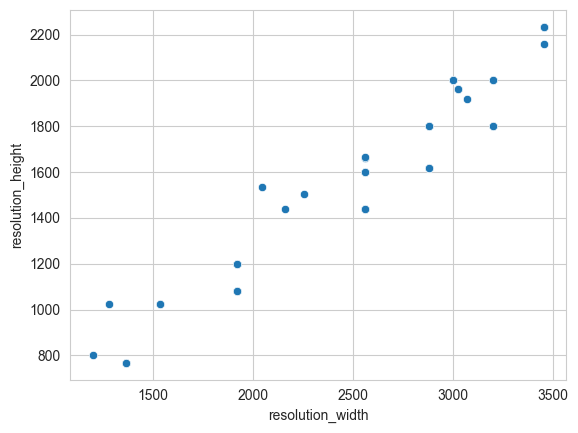

In [262]:
# podmiana złej rozdzielczości
mask = df.resolution_width <= df.resolution_height
df.loc[mask,["resolution_width","resolution_height"]] = df.loc[mask,["resolution_height","resolution_width"]].values

# create distribution plot 2d for resolution width and height
sns.scatterplot(data=df,x='resolution_width',y='resolution_height')

# Columns to encode:
- brand
- columns that will be created from the Model column
- - We decided not to encode exact os, because it is too detailed and there are too many different values and it does not seem to be very important and give us much information
- - We decided not to encode generation of processor, because it was too problematic and we had only partial information about it
- - We just focused on encoding exact model name here.
- processor brand
- processor tier
- primary_storage_type
- secondary_storage_type
- gpu_brand
- gpu_type
- is_touch_screen (binary encoding)
- OS

In [263]:
def extract_info_from_Model_column(df):
    # take first word of the model column
    df2=df.copy()
    df2['model_rest']=df2['Model'].str.split('(').str[0]
    # remove first word in model_rest and to string
    df2['model_rest']=df2['model_rest'].str.split(' ').str[1:].str.join(' ')
    # first word in model_rest is exact_model
    df2['exact_model']=df2['model_rest'].str.split(' ').str[0]
    df2.drop(columns=['model_rest', 'Model'],inplace=True)
    # lower case, remove special characters, remove multiple spaces, remove leading and trailing spaces
    df2['exact_model']=df2['exact_model'].str.lower().str.replace(r'[^\w\s]','').str.replace(r'\s+',' ').str.strip()
    # if in exact_model value is less popular than 3, then replace it with 'other'
    df2['exact_model']=df2['exact_model'].where(df2['exact_model'].map(df2['exact_model'].value_counts())>3,'other')
    return df2

df2=extract_info_from_Model_column(df)
df2

,brand,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,exact_model
0,msi,43990,53,amd,ryzen 5,6,12,8,SSD,512,...,0,amd,integrated,False,15.6,1920,1080,windows,1,modern
1,msi,119990,73,intel,core i7,14,20,16,SSD,1024,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,other
2,acer,45990,59,intel,core i5,4,8,8,SSD,512,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,aspire
3,msi,449990,89,intel,core i9,24,32,4,SSD,2048,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,other
4,acer,41490,45,intel,core i3,8,8,8,SSD,512,...,0,intel,integrated,False,14.0,1920,1200,windows,1,aspire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,acer,37990,60,amd,ryzen 5,6,12,16,SSD,512,...,0,amd,integrated,False,15.6,1920,1080,windows,1,aspire
689,hp,59871,71,amd,ryzen 5,6,12,8,SSD,512,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,victus
690,dell,47990,63,intel,core i5,4,8,8,SSD,512,...,0,intel,integrated,False,15.6,1920,1080,windows,1,vostro
691,hp,74999,64,intel,core i5,10,12,8,SSD,512,...,0,intel,integrated,False,14.0,1366,768,windows,1,other


In [264]:
def encode_brand(df):
    # if brand appears less than 4 times, then replace it with 'other'
    df['brand']=df['brand'].where(df['brand'].map(df['brand'].value_counts())>4,'other')
    one_hot = OneHotEncoder()
    X = one_hot.fit_transform(df['brand'].values.reshape(-1,1)).toarray()
    X=X.astype(int)
    dfOneHot = pd.DataFrame(X, columns = ["brand_"+str(one_hot.categories_[0][i]) for i in range(X.shape[1])])
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns=['brand'],inplace=True)
    return df

df2=encode_brand(df2)
df2

,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,...,brand_acer,brand_apple,brand_asus,brand_dell,brand_hp,brand_infinix,brand_lenovo,brand_lg,brand_msi,brand_other
0,43990,53,amd,ryzen 5,6,12,8,SSD,512,No secondary storage,...,0,0,0,0,0,0,0,0,1,0
1,119990,73,intel,core i7,14,20,16,SSD,1024,No secondary storage,...,0,0,0,0,0,0,0,0,1,0
2,45990,59,intel,core i5,4,8,8,SSD,512,No secondary storage,...,1,0,0,0,0,0,0,0,0,0
3,449990,89,intel,core i9,24,32,4,SSD,2048,No secondary storage,...,0,0,0,0,0,0,0,0,1,0
4,41490,45,intel,core i3,8,8,8,SSD,512,No secondary storage,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,amd,ryzen 5,6,12,16,SSD,512,No secondary storage,...,1,0,0,0,0,0,0,0,0,0
689,59871,71,amd,ryzen 5,6,12,8,SSD,512,No secondary storage,...,0,0,0,0,1,0,0,0,0,0
690,47990,63,intel,core i5,4,8,8,SSD,512,No secondary storage,...,0,0,0,1,0,0,0,0,0,0
691,74999,64,intel,core i5,10,12,8,SSD,512,No secondary storage,...,0,0,0,0,1,0,0,0,0,0


In [265]:
def encode_processor_brand(df):
    one_hot = OneHotEncoder()
    X = one_hot.fit_transform(df['processor_brand'].values.reshape(-1,1)).toarray()
    # change X to int
    X = X.astype(int)
    dfOneHot = pd.DataFrame(X, columns = ["processor_brand_"+str(one_hot.categories_[0][i]) for i in range(X.shape[1])])
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns=['processor_brand'],inplace=True)
    return df

df2=encode_processor_brand(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,...,brand_hp,brand_infinix,brand_lenovo,brand_lg,brand_msi,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other
0,43990,53,ryzen 5,6,12,8,SSD,512,No secondary storage,0,...,0,0,0,0,1,0,1,0,0,0
1,119990,73,core i7,14,20,16,SSD,1024,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
2,45990,59,core i5,4,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
3,449990,89,core i9,24,32,4,SSD,2048,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
4,41490,45,core i3,8,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,ryzen 5,6,12,16,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,1,0,0,0
689,59871,71,ryzen 5,6,12,8,SSD,512,No secondary storage,0,...,1,0,0,0,0,0,1,0,0,0
690,47990,63,core i5,4,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
691,74999,64,core i5,10,12,8,SSD,512,No secondary storage,0,...,1,0,0,0,0,0,0,0,1,0


In [266]:
def encode_processor_tier(df):
    new_column=df['processor_tier'].str.extract(r'(\d)')
    new_column.fillna(0,inplace=True)
    df['processor_tier']=new_column
    return df

df2=encode_processor_tier(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,...,brand_hp,brand_infinix,brand_lenovo,brand_lg,brand_msi,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other
0,43990,53,5,6,12,8,SSD,512,No secondary storage,0,...,0,0,0,0,1,0,1,0,0,0
1,119990,73,7,14,20,16,SSD,1024,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
2,45990,59,5,4,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
3,449990,89,9,24,32,4,SSD,2048,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
4,41490,45,3,8,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,1,0,0,0
689,59871,71,5,6,12,8,SSD,512,No secondary storage,0,...,1,0,0,0,0,0,1,0,0,0
690,47990,63,5,4,8,8,SSD,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
691,74999,64,5,10,12,8,SSD,512,No secondary storage,0,...,1,0,0,0,0,0,0,0,1,0


In [267]:
def encode_primary_storage_type(df):
    # if SSD 1, if HDD 0
    df['primary_storage_type']=np.where(df['primary_storage_type']=='SSD',1,0)
    #change name of column to primary_storage_is_SSD
    df.rename(columns={'primary_storage_type':'primary_storage_is_SSD'},inplace=True)
    return df

df2=encode_primary_storage_type(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,...,brand_hp,brand_infinix,brand_lenovo,brand_lg,brand_msi,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other
0,43990,53,5,6,12,8,1,512,No secondary storage,0,...,0,0,0,0,1,0,1,0,0,0
1,119990,73,7,14,20,16,1,1024,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
2,45990,59,5,4,8,8,1,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
3,449990,89,9,24,32,4,1,2048,No secondary storage,0,...,0,0,0,0,1,0,0,0,1,0
4,41490,45,3,8,8,8,1,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,No secondary storage,0,...,0,0,0,0,0,0,1,0,0,0
689,59871,71,5,6,12,8,1,512,No secondary storage,0,...,1,0,0,0,0,0,1,0,0,0
690,47990,63,5,4,8,8,1,512,No secondary storage,0,...,0,0,0,0,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,No secondary storage,0,...,1,0,0,0,0,0,0,0,1,0


In [268]:
def encode_secondary_storage_type(df):
    # we can drop this column, because it is not very informative
    # we have second column that informs us about capacity of secondary storage and it is always SSD
    df=df.drop(columns=['secondary_storage_type'])
    return df

df2=encode_secondary_storage_type(df2)
df2


,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_brand,...,brand_hp,brand_infinix,brand_lenovo,brand_lg,brand_msi,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other
0,43990,53,5,6,12,8,1,512,0,amd,...,0,0,0,0,1,0,1,0,0,0
1,119990,73,7,14,20,16,1,1024,0,nvidia,...,0,0,0,0,1,0,0,0,1,0
2,45990,59,5,4,8,8,1,512,0,nvidia,...,0,0,0,0,0,0,0,0,1,0
3,449990,89,9,24,32,4,1,2048,0,nvidia,...,0,0,0,0,1,0,0,0,1,0
4,41490,45,3,8,8,8,1,512,0,intel,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,amd,...,0,0,0,0,0,0,1,0,0,0
689,59871,71,5,6,12,8,1,512,0,nvidia,...,1,0,0,0,0,0,1,0,0,0
690,47990,63,5,4,8,8,1,512,0,intel,...,0,0,0,0,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,0,intel,...,1,0,0,0,0,0,0,0,1,0


In [269]:
def encode_gpu_brand(df):
    one_hot = OneHotEncoder()
    X = one_hot.fit_transform(df['gpu_brand'].values.reshape(-1,1)).toarray()
    X = X.astype(int)
    dfOneHot = pd.DataFrame(X, columns = ["gpu_brand_"+str(one_hot.categories_[0][i]) for i in range(X.shape[1])])
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns=['gpu_brand'],inplace=True)
    return df

df2=encode_gpu_brand(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_type,...,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other,gpu_brand_amd,gpu_brand_apple,gpu_brand_arm,gpu_brand_intel,gpu_brand_nvidia
0,43990,53,5,6,12,8,1,512,0,integrated,...,0,1,0,0,0,1,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,dedicated,...,0,0,0,1,0,0,0,0,0,1
2,45990,59,5,4,8,8,1,512,0,dedicated,...,0,0,0,1,0,0,0,0,0,1
3,449990,89,9,24,32,4,1,2048,0,dedicated,...,0,0,0,1,0,0,0,0,0,1
4,41490,45,3,8,8,8,1,512,0,integrated,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,integrated,...,0,1,0,0,0,1,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,dedicated,...,0,1,0,0,0,0,0,0,0,1
690,47990,63,5,4,8,8,1,512,0,integrated,...,0,0,0,1,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,0,integrated,...,0,0,0,1,0,0,0,0,1,0


In [270]:
def encode_gpu_type(df):
    # if apple then mark it as integrated
    df['gpu_type']=np.where(df['gpu_type']=='apple','integrated',df['gpu_type'])
    #if dedicated 1, if integrated 0
    df['gpu_type']=np.where(df['gpu_type']=='dedicated',1,0)
    #change name of column to gpu_is_dedicated
    df.rename(columns={'gpu_type':'gpu_is_dedicated'},inplace=True)
    return df

df2=encode_gpu_type(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other,gpu_brand_amd,gpu_brand_apple,gpu_brand_arm,gpu_brand_intel,gpu_brand_nvidia
0,43990,53,5,6,12,8,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,1,0,0,0,0,0,1
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,1,0,0,0,0,0,1
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,1,0,0,0,0,0,1
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,1,0,0,0,0,0,0,0,1
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0


In [271]:
def encode_is_touch_screen(df):
    # if touch screen 1, if not 0
    df['is_touch_screen']=np.where(df['is_touch_screen']==True,1,0)
    return df

df2=encode_is_touch_screen(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other,gpu_brand_amd,gpu_brand_apple,gpu_brand_arm,gpu_brand_intel,gpu_brand_nvidia
0,43990,53,5,6,12,8,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,1,0,0,0,0,0,1
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,1,0,0,0,0,0,1
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,1,0,0,0,0,0,1
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,1,0,0,0,0,0,0,0,1
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0


In [272]:
df2['OS'].value_counts()

OS
windows    647
dos         22
chrome      14
mac          9
other        1
Name: count, dtype: int64

In [273]:
def encode_OS(df):
    #if windows 1, if not windows 0
    # because other OS are not very popular in this dataset
    df['OS']=np.where(df['OS']=='windows',1,0)
    # change name of column to OS_is_windows
    df.rename(columns={'OS':'OS_is_windows'},inplace=True)
    return df
    
df2=encode_OS(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,brand_other,processor_brand_amd,processor_brand_apple,processor_brand_intel,processor_brand_other,gpu_brand_amd,gpu_brand_apple,gpu_brand_arm,gpu_brand_intel,gpu_brand_nvidia
0,43990,53,5,6,12,8,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,1,0,0,0,0,0,1
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,1,0,0,0,0,0,1
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,1,0,0,0,0,0,1
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,1,0,0,0,1,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,1,0,0,0,0,0,0,0,1
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,1,0,0,0,0,1,0


In [274]:
def encode_model(df):
    one_hot = OneHotEncoder()
    X = one_hot.fit_transform(df['exact_model'].values.reshape(-1,1)).toarray()
    X = X.astype(int)
    dfOneHot = pd.DataFrame(X, columns = ["model_"+str(one_hot.categories_[0][i]) for i in range(X.shape[1])])
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns=['exact_model'],inplace=True)
    return df

df2=encode_model(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,43990,53,5,6,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,0,0,0,0,0,0,0
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,0,0,0,0,0,0,0
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,0,0,0,0,0,0,0
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,0,0,0,1,0,0,0,0,0
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,0,0,0,1,0,0,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
def encode_year_of_warranty(df):
    # if not a number then 0
    df['year_of_warranty']=df['year_of_warranty'].str.extract(r'(\d+)')
    df['year_of_warranty']=df['year_of_warranty'].fillna(0)
    return df

df2=encode_year_of_warranty(df2)
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,43990,53,5,6,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,0,0,0,0,0,0,0
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,0,0,0,0,0,0,0
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,0,0,0,0,0,0,0
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,0,0,0,1,0,0,0,0,0
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,0,0,0,1,0,0,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0


# Encoding is done, now we can save the data

In [276]:
df2.to_csv("../../data/modelers_data_encoded.csv",index=False)

In [277]:
df2=pd.read_csv("../../data/modelers_data_encoded.csv")
df2

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,43990,53,5,6,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
1,119990,73,7,14,20,16,1,1024,0,1,...,0,0,0,0,0,0,0,0,0,0
2,45990,59,5,4,8,8,1,512,0,1,...,0,0,0,0,0,0,0,0,0,0
3,449990,89,9,24,32,4,1,2048,0,1,...,0,0,0,0,0,0,0,0,0,0
4,41490,45,3,8,8,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,37990,60,5,6,12,16,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0
689,59871,71,5,6,12,8,1,512,0,1,...,0,0,0,0,1,0,0,0,0,0
690,47990,63,5,4,8,8,1,512,0,0,...,0,0,0,0,0,0,1,0,0,0
691,74999,64,5,10,12,8,1,512,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
# funkcje do wykresów z zajęć
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=101)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1  # score returns -WCSS
        scores.append(wcss)
    return scores


# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num

    scores = []
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state=101)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)

    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores


def metrics_plots(X, max_k=10):
    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state=101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d]
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin']
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()


Text(0.5, 1.0, 'Metoda silhouette')

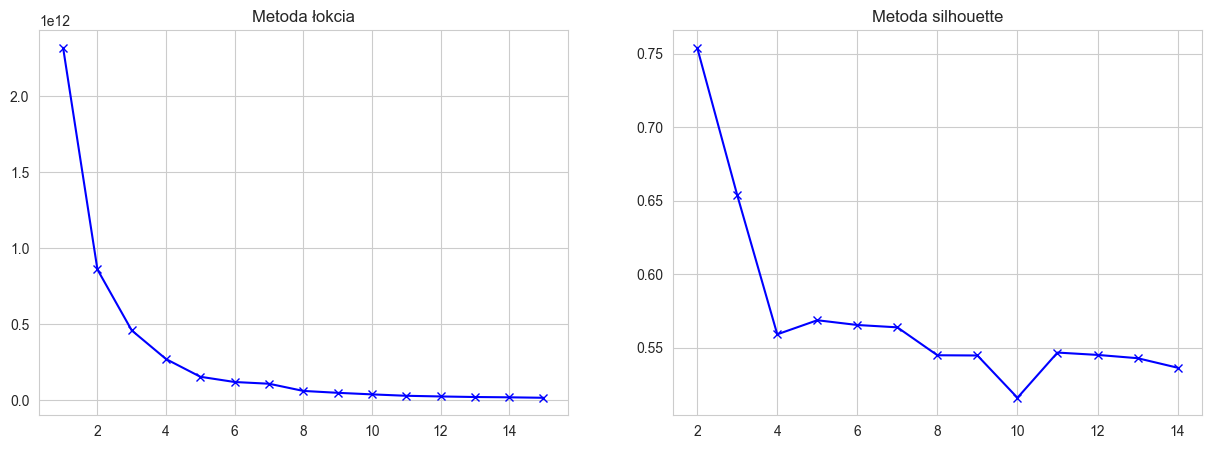

In [279]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
wcss_vec = count_wcss_scores(df2, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
axis[0].plot(x_ticks, wcss_vec, 'bx-')
axis[0].set_title("Metoda łokcia")
cluster_num_seq = range(2, 15) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(df2, cluster_num_seq, KMeans, silhouette_score)
axis[1].plot(cluster_num_seq, silhouette_vec, 'bx-')
axis[1].set_title("Metoda silhouette")

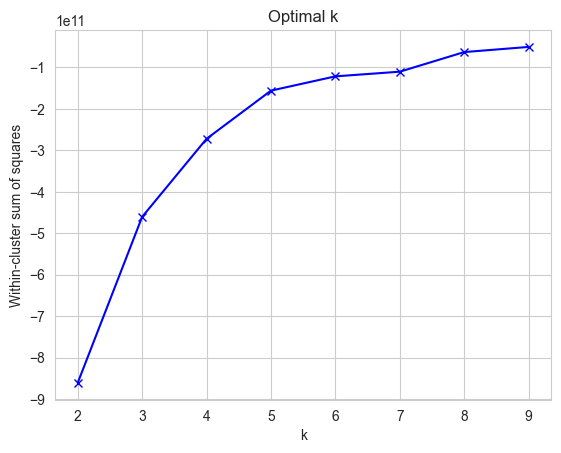

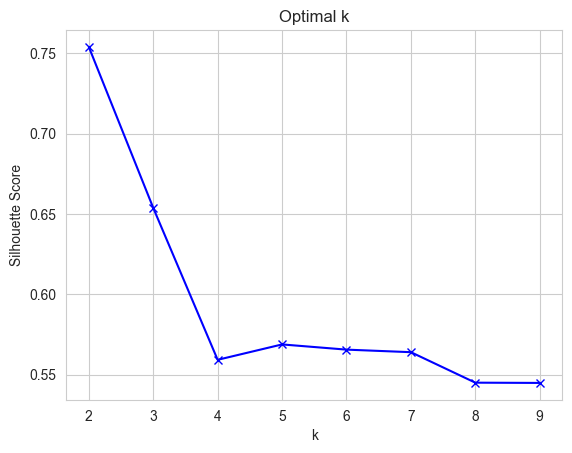

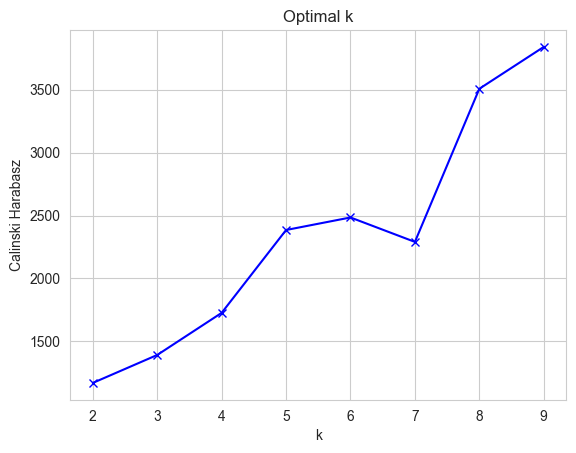

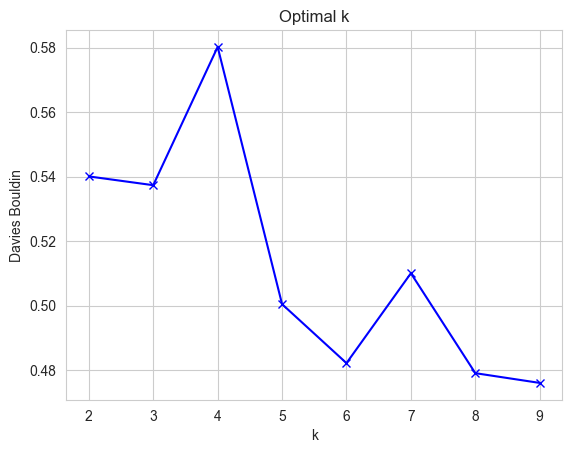

In [280]:
metrics_plots(df2,max_k=10)

# Aglomerative Clustering

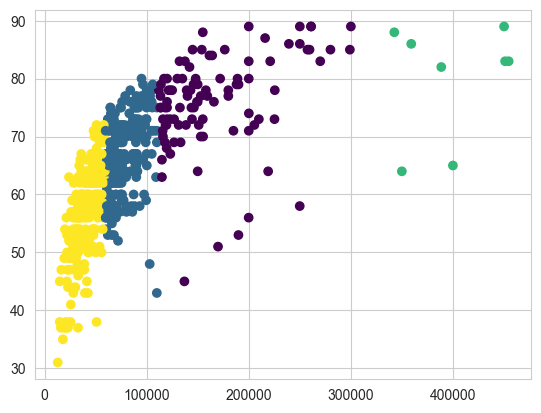

In [281]:
model_matrix = df2.values
model = AgglomerativeClustering(n_clusters=4)
y_aggc = model.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_aggc, cmap='viridis')
plt.show()

In [282]:
model_matrix = df2.values
model_aggc_6 = AgglomerativeClustering(n_clusters=6)
model_aggc_5 = AgglomerativeClustering(n_clusters=5)
model_aggc_7 = AgglomerativeClustering(n_clusters=7)

y_aggc_6 = model_aggc_6.fit_predict(model_matrix)
y_aggc_5 = model_aggc_5.fit_predict(model_matrix)
y_aggc_7 = model_aggc_7.fit_predict(model_matrix)

# Kmeans

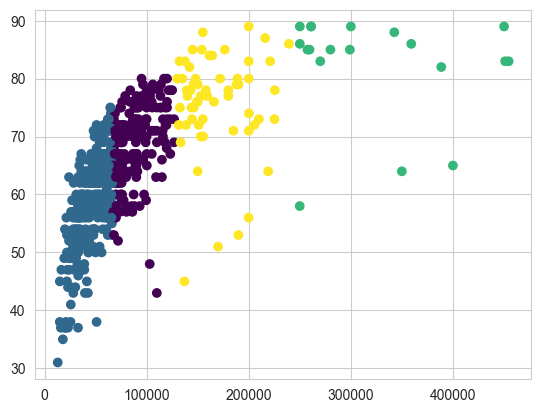

In [283]:
model_matrix = df2.values
model_kmeans = KMeans(n_clusters=4)
y_km = model_kmeans.fit_predict(df2)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_km, cmap='viridis')
# centers = model_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.show()

# DBSCAN

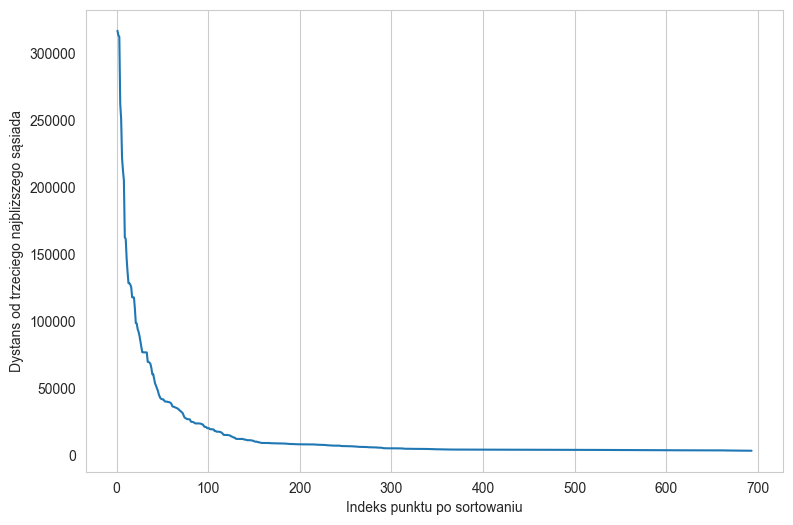

In [284]:
model_matrix = df2.values
minPts = model_matrix.shape[1]
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(model_matrix)
distances, indices = nbrs.kneighbors(model_matrix)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,model_matrix.shape[0]+1)), distanceDec)

# plt.xscale('log')
plt.grid(axis='y')

plt.show()

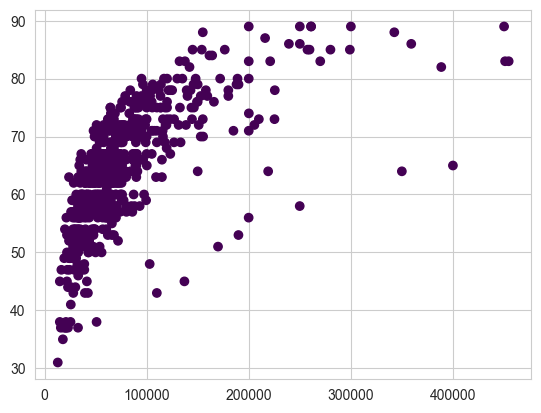

In [285]:
model_dbscan = DBSCAN(eps=1.41,min_samples=7)
y_dbscan = model_dbscan.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_dbscan, cmap='viridis')
plt.show()


# XD

# Gaussian Mixture Model

/var/folders/7q/jtsqqb2j4bj4j9t6p9c76vw00000gn/T/ipykernel_38863/406371803.py:4: RuntimeWarning: overflow encountered in exp
  plt.scatter(np.exp(model_matrix[:, 0]), model_matrix[:, 1], c=y_gmm, cmap='viridis')


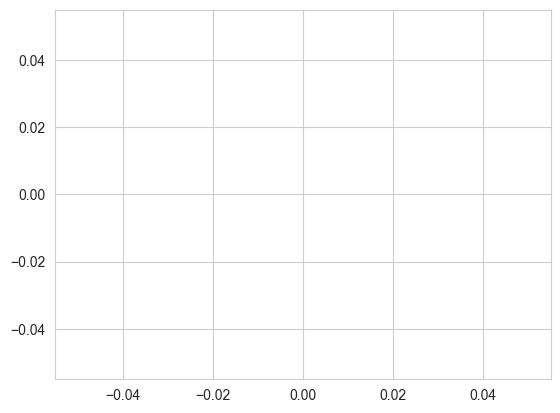

In [286]:
model_matrix = df2.values
model_gmm = mixture.GaussianMixture(n_components=4, covariance_type="full")
y_gmm = model_gmm.fit_predict(model_matrix)
plt.scatter(np.exp(model_matrix[:, 0]), model_matrix[:, 1], c=y_gmm, cmap='viridis')
plt.show()

In [287]:
model_gmm_5 = mixture.GaussianMixture(n_components=5, covariance_type="full")
model_gmm_7 = mixture.GaussianMixture(n_components=7, covariance_type="full")
model_gmm_6 = mixture.GaussianMixture(n_components=6, covariance_type="full")

y_gmm_5 = model_gmm_5.fit_predict(model_matrix)
y_gmm_7 = model_gmm_7.fit_predict(model_matrix)
y_gmm_6 = model_gmm_6.fit_predict(model_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 1396.547714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.951637
[t-SNE] KL divergence after 3400 iterations: 0.154305


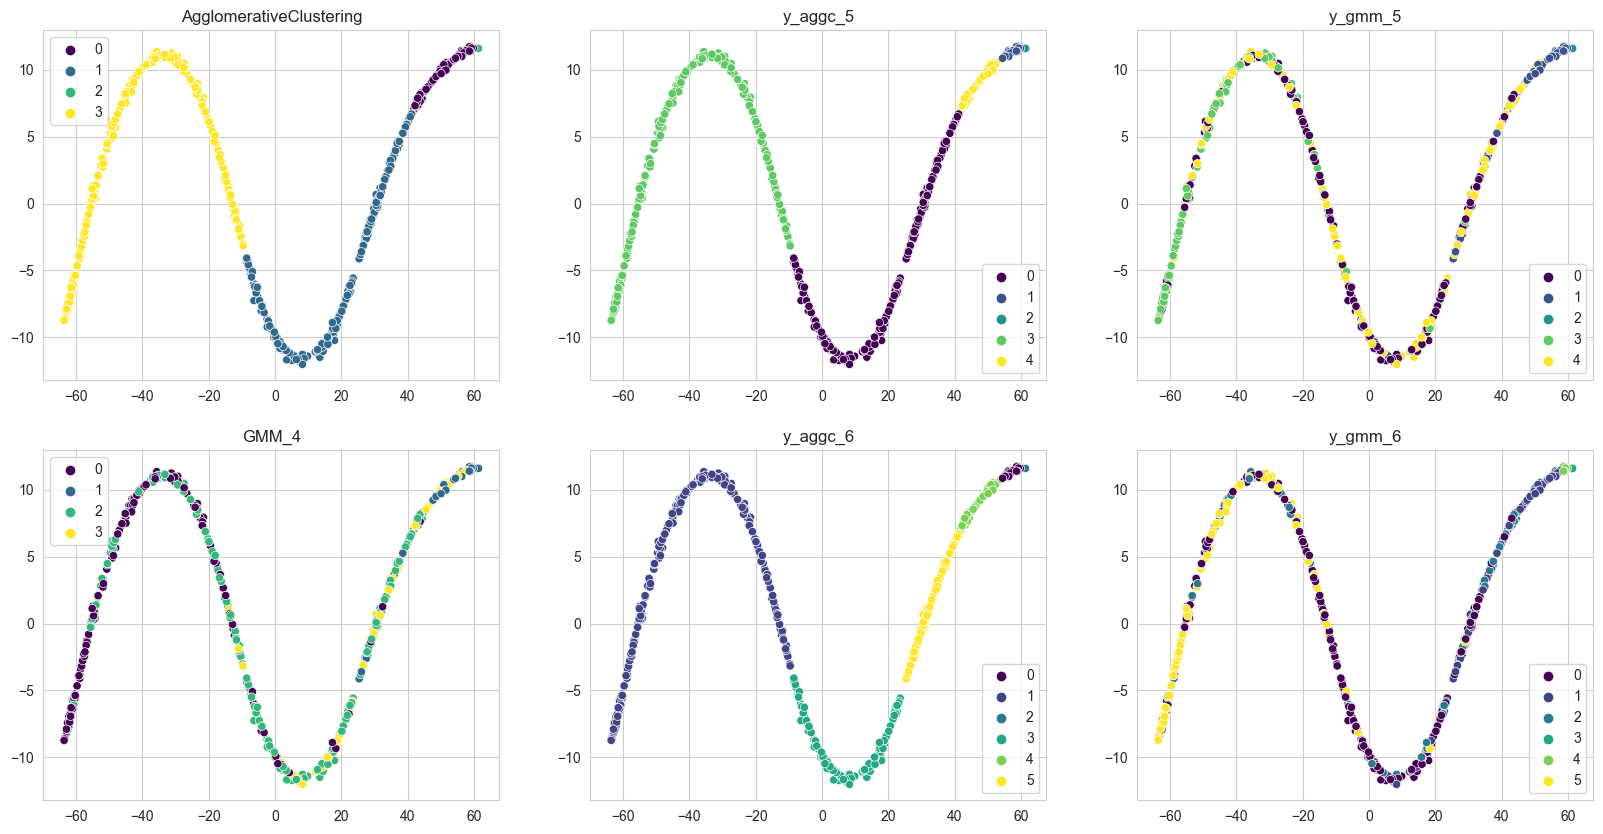

In [288]:
df2_copy = df2.copy()
tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
digits_proj = tSNE.fit_transform(df2_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_aggc_5,y_gmm_5,y_gmm,y_aggc_6,y_gmm_6]
predictions_title = ['AgglomerativeClustering','y_aggc_5','y_gmm_5','GMM_4','y_aggc_6','y_gmm_6']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

# Price Distribution

Text(0.5, 1.0, 'Rozkład log(price)')

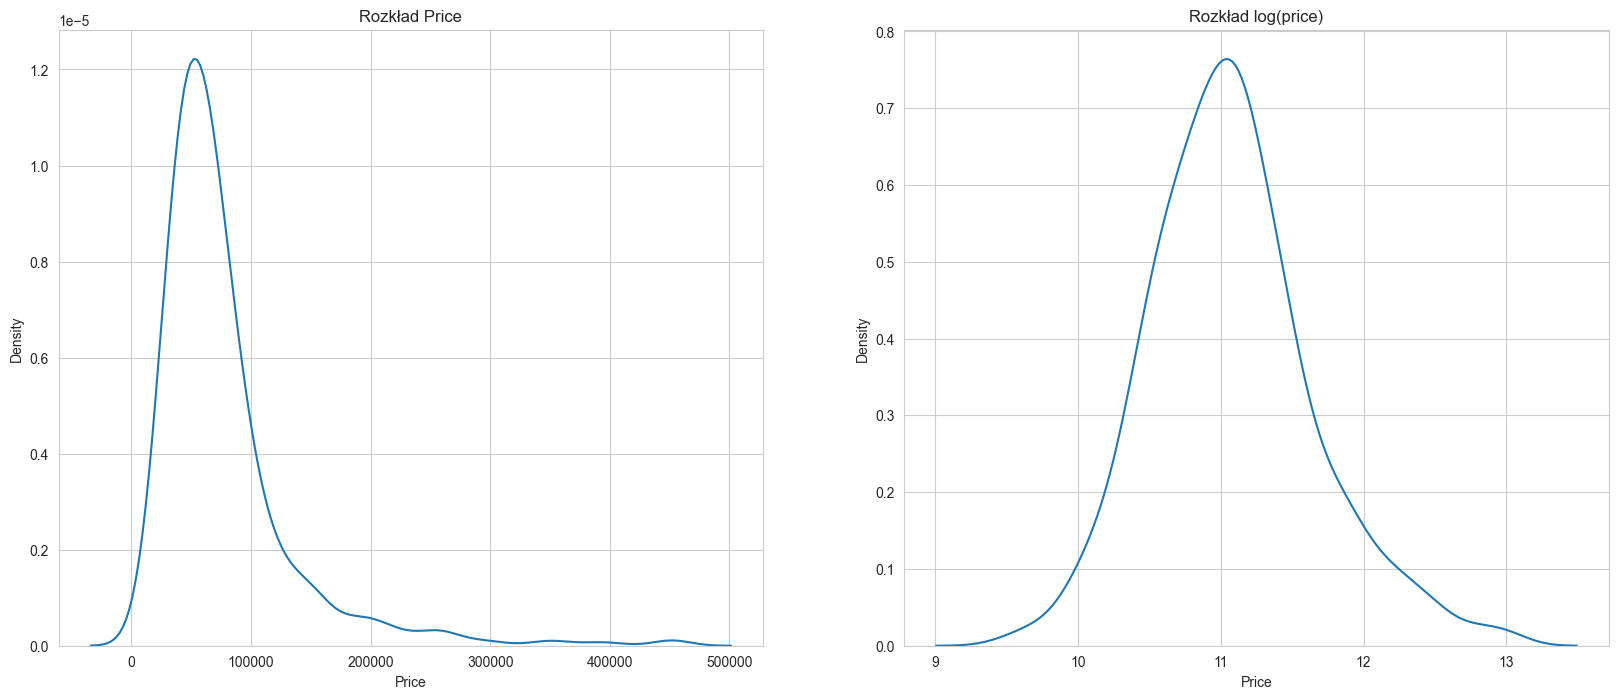

In [289]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.kdeplot(x=df2.Price,ax=ax[0])
ax[0].set_title("Rozkład Price")
sns.kdeplot(x=np.log(df2.Price),ax=ax[1])
ax[1].set_title("Rozkład log(price)")

In [290]:
def scale_data(df):
    # log transformation of price
    df['Price']=np.log(df['Price'])
    # standard scaling of all columns
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = min_max_scaler.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

df2_scaled=scale_data(df2)
df2_scaled

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,0.343118,0.379310,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.625381,0.724138,0.777778,0.545455,0.625,0.375,1.0,0.492063,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355625,0.482759,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997201,1.000000,1.000000,1.000000,1.000,0.000,1.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.326659,0.241379,0.333333,0.272727,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0.301869,0.500000,0.555556,0.181818,0.375,0.375,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0.429821,0.689655,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
690,0.367599,0.551724,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
691,0.493192,0.568966,0.555556,0.363636,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [291]:
df2_scaled.to_csv("../../data/modelers_data_encoded_scaled.csv",index=False)

In [292]:
df2_scaled=pd.read_csv("../../data/modelers_data_encoded_scaled.csv")
df2_scaled

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,0.343118,0.379310,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.625381,0.724138,0.777778,0.545455,0.625,0.375,1.0,0.492063,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355625,0.482759,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997201,1.000000,1.000000,1.000000,1.000,0.000,1.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.326659,0.241379,0.333333,0.272727,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0.301869,0.500000,0.555556,0.181818,0.375,0.375,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0.429821,0.689655,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
690,0.367599,0.551724,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
691,0.493192,0.568966,0.555556,0.363636,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DBSCAN after scaling

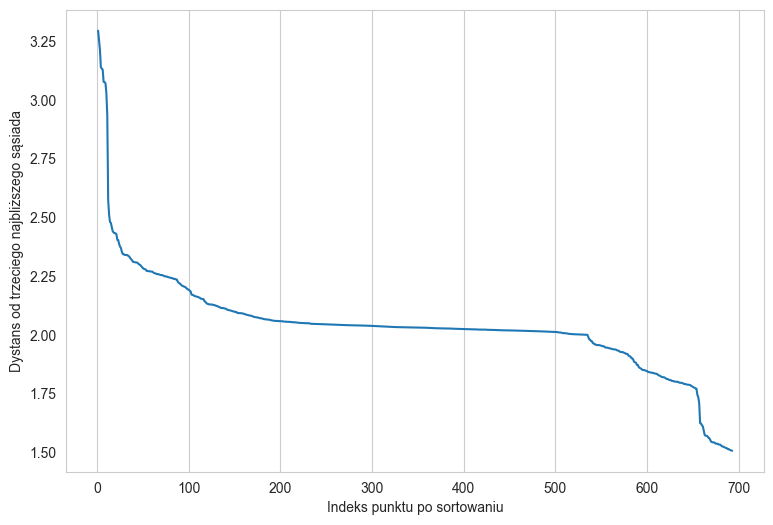

In [293]:
model_matrix = df2_scaled.values
minPts = model_matrix.shape[1]
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(model_matrix)
distances, indices = nbrs.kneighbors(model_matrix)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,model_matrix.shape[0]+1)), distanceDec)

# plt.xscale('log')
plt.grid(axis='y')

plt.show()

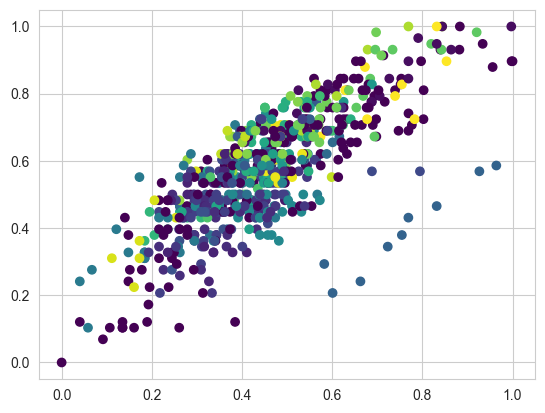

In [294]:
model_dbscan = DBSCAN(eps=1.41,min_samples=7)
y_dbscan = model_dbscan.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_dbscan, cmap='viridis')
plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.002s...
[t-SNE] Computed neighbors for 693 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 3.777544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.757675
[t-SNE] KL divergence after 5200 iterations: 0.193578


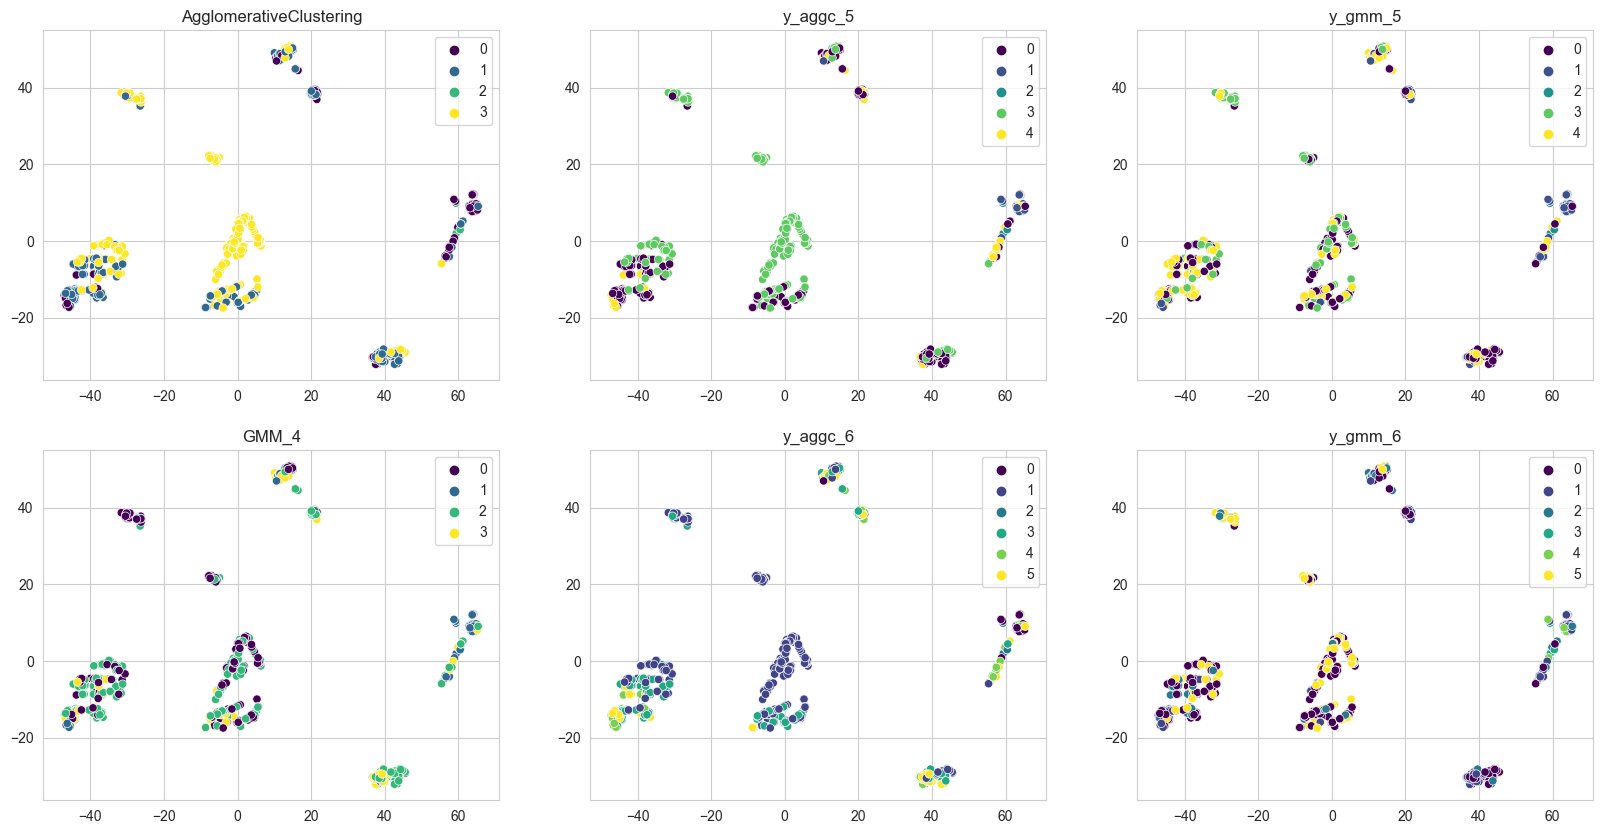

In [295]:
df2_copy = df2.copy()
tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
digits_proj = tSNE.fit_transform(df2_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_aggc_5,y_gmm_5,y_gmm,y_aggc_6,y_gmm_6]
predictions_title = ['AgglomerativeClustering','y_aggc_5','y_gmm_5','GMM_4','y_aggc_6','y_gmm_6']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

# PCA

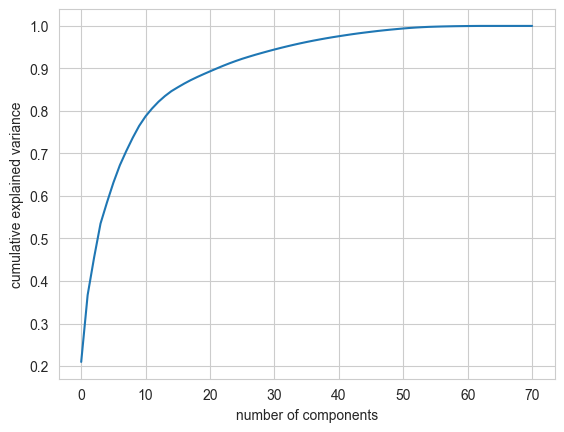

In [296]:
# check how many components we need
pca = PCA()
pca.fit(df2_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# We need 30 components to explain around 95% of variance

In [297]:
pca = PCA(n_components=30)
pca.fit(df2_scaled)
df2_pca = pca.transform(df2_scaled)
df2_pca = pd.DataFrame(df2_pca)
df2_pca

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.361847,1.310215,-0.003233,-0.154531,0.604639,0.325115,0.121305,0.059084,0.364644,-0.992356,...,0.106361,-0.217767,0.095222,-0.394793,-0.099425,-0.432578,-0.272143,0.021421,-0.268887,-0.018866
1,0.844164,-0.943544,-0.529082,-0.371155,0.384129,0.563302,0.742743,0.066195,0.219556,-0.216329,...,-0.029961,-0.099432,0.104083,0.045160,0.097330,-0.018396,0.002691,0.071034,-0.008891,0.091056
2,0.613966,-0.666679,-0.236844,0.040290,0.396791,0.474337,-1.055056,0.644189,-0.263481,0.204348,...,-0.073547,-0.112543,-0.203298,-0.008866,0.164301,-0.143964,-0.100243,0.029398,-0.058631,0.043011
3,1.005444,-1.097836,-0.554519,-0.410198,0.436704,0.301418,1.042366,0.336185,0.235572,-0.170898,...,-0.071110,-0.073099,0.084768,0.011734,0.123449,0.072648,-0.070971,0.248825,0.022652,0.361545
4,-0.939509,-0.175662,-0.026275,0.048809,0.433744,0.310010,-0.890288,0.858485,-0.210017,0.078934,...,-0.084910,-0.139444,-0.170060,-0.009740,0.112405,-0.030865,-0.108675,0.071883,0.036946,-0.005046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0.287752,1.352951,0.063552,-0.113480,0.691336,0.286210,-0.664181,1.021759,-0.251459,0.010915,...,-0.083850,-0.098942,-0.230932,0.067660,0.193672,-0.033268,-0.025070,0.027659,-0.014369,-0.095195
689,1.252217,0.416514,-0.457024,-0.580992,-0.618904,-0.251081,-0.583814,-0.316307,-0.163561,0.064132,...,-0.110849,0.046991,0.054287,-0.014181,0.017370,0.039586,-0.057973,0.064839,0.010054,0.039754
690,-0.865571,-0.196291,-0.021141,0.043013,0.621859,-0.397979,-0.208338,-0.402876,-0.161534,0.022526,...,-0.312502,0.126206,-0.287401,-0.253352,-0.205561,0.195995,-0.164831,0.047448,0.256451,0.118594
691,-0.944871,-0.117868,-0.518221,-0.789080,-0.419461,0.171411,0.233928,-0.097030,-0.257437,0.112909,...,0.022866,0.130092,-0.076263,-0.076952,-0.011990,0.038658,-0.068155,0.000286,0.047444,-0.041280


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


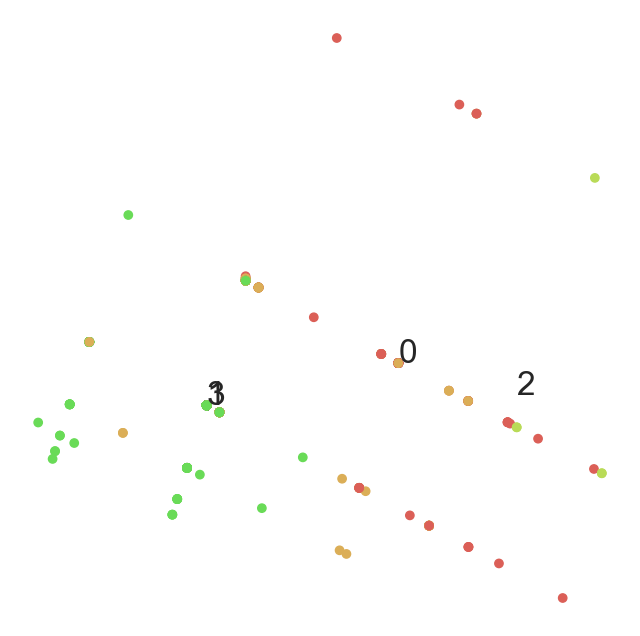

In [298]:

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1],
                    c=palette[colors.astype(int)])
    # plt.xlim(-25, 25)
    # plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

#używając samego PCA widoczne są 4 klastry i AgglomerativeClustering(4) sprawdza się najlepiej (perfekcyjnie wsm w porownaniu z kazdym innym)
pca = PCA(n_components = 2)
digits_proj_pca = pca.fit_transform(df2)
scatter(digits_proj_pca, y_aggc)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.001s...
[t-SNE] Computed neighbors for 693 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 3.772059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.740810


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.205006


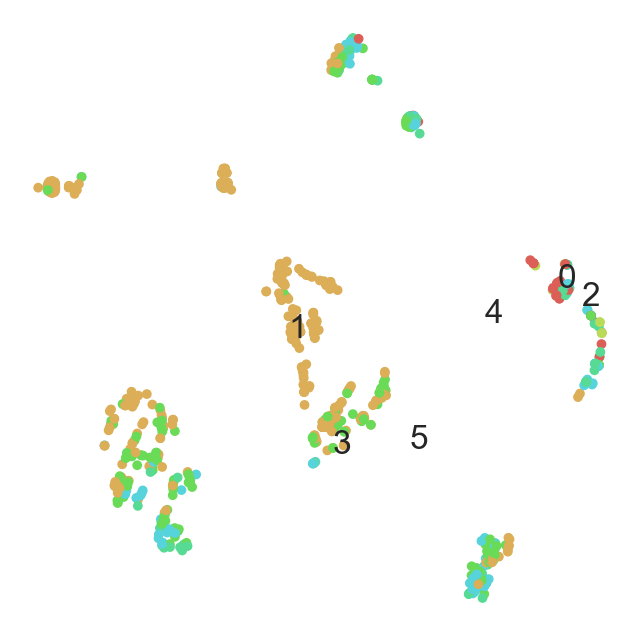

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


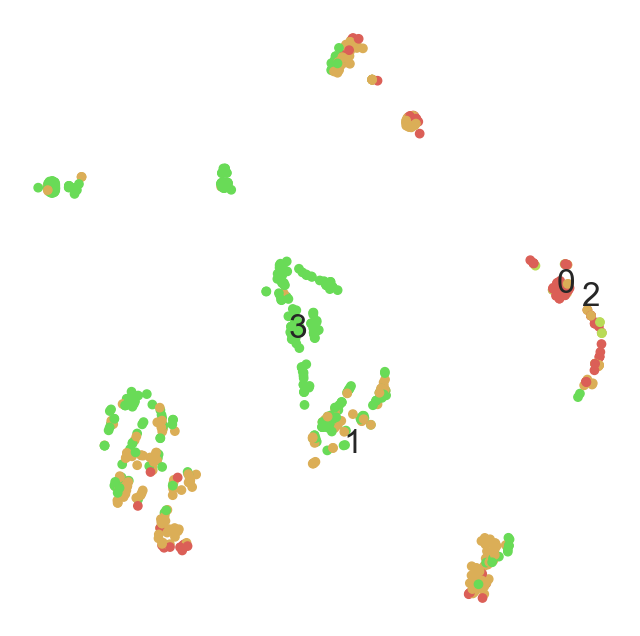

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


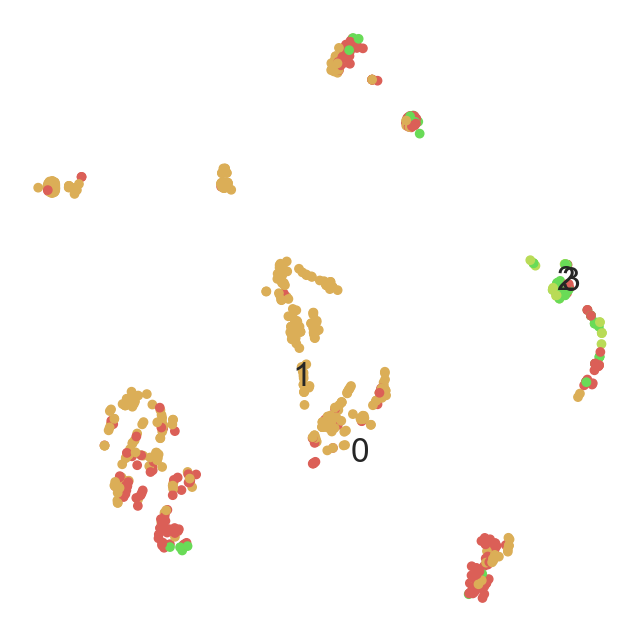

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


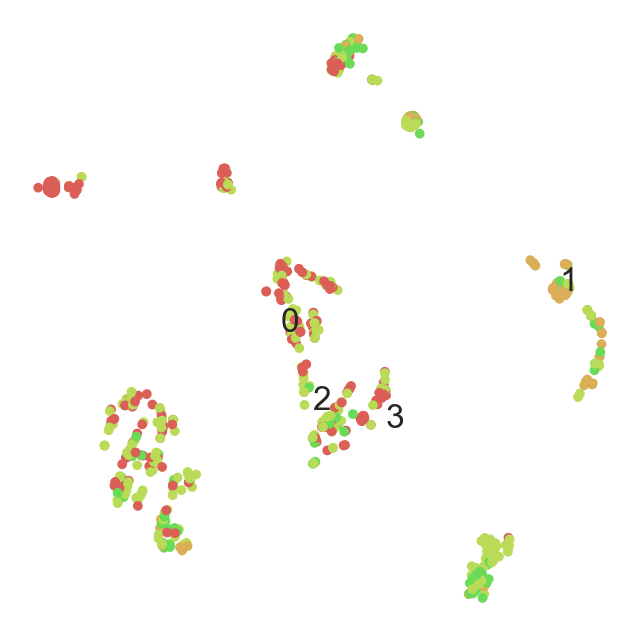

In [299]:
X_pca =  PCA(n_components=30).fit_transform(df2_copy)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y_aggc_6)
scatter(digits_proj, y_aggc)
scatter(digits_proj, y_km)
scatter(digits_proj, y_gmm)

plt.show()